In [1]:
from torch import nn
import torch, gym, gym_unbalanced_disk, time, gym.wrappers
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from os import path

In [2]:
class Qfunction(nn.Module):
    def __init__(self, env):
        super(Qfunction,self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 40)
        self.F1 =  nn.Tanh() #a)
        self.lay2 = nn.Linear(40,env.action_space.n)
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs)))

In [3]:
def show(Q,env,setting):
    u = []
    theta = []
    omega = []
    with torch.no_grad():
        #you can use Qfun(obs) as a shorthand for the q function.
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() #convert x to torch.tensor -> put in the Q function -> back to numpy
        try:
            obs = env.reset() #b)
            env.render() #b)
            time.sleep(1) #b)
            while True: #b)
                action = np.argmax(Qfun(obs)) #b)
                obs, reward, done, info = env.step(action) #b)
                time.sleep(1/60) #b)
                env.render() #b)
                if setting == "u":
                    print(env.u)
                elif setting == 'omega':
                    print(env.omega)
                elif setting == 'theta':
                    print(env.th)
                u.append(env.u)
                theta.append(env.th)
                omega.append(env.omega)
                if done: #b)
                    time.sleep(0.5)  #b)
                    break  #b)
        finally: #this will always run even when an error occurs
            env.close()
            return u,theta,omega

In [4]:
def rollout(Q, env, epsilon=0.1, N_rollout=10_000): 
    #save the following (use .append)
    Start_state = [] #hold an array of (x_t)
    Actions = [] #hold an array of (u_t)
    Rewards = [] #hold an array of (r_{t+1})
    End_state = [] #hold an array of (x_{t+1})
    Terminal = [] #hold an array of (terminal_{t+1})
    # Qfun( a numpy array of the obs) -> a numpy array of Q values
    Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() 
    with torch.no_grad():
        
        obs = env.reset() #c)
        for i in range(N_rollout): #c)
            if np.random.uniform()>epsilon: #c)
                Qnow = Qfun(obs) #c)
                action = np.argmax(Qnow) #c)
            else: #c)
                action = env.action_space.sample() #c)
            Start_state.append(obs) #c)
            Actions.append(action) #c)

            obs_next, reward, done, info = env.step(action) #c)
            terminal = done and not info.get('TimeLimit.truncated', False) #c)

            Terminal.append(terminal) #c)
            Rewards.append(reward) #c)
            End_state.append(obs_next) #c)

            if done: #c)
                obs = env.reset() #c)
            else: #c)
                obs = obs_next #c)
                
    #error checking:
    assert len(Start_state)==len(Actions)==len(Rewards)==len(End_state)==len(Terminal), f'error in lengths: {len(Start_state)}=={len(Actions)}=={len(Rewards)}=={len(End_state)}=={len(Dones)}'
    return np.array(Start_state), np.array(Actions), np.array(Rewards), np.array(End_state), np.array(Terminal).astype(int)

In [5]:
def eval_Q(Q,env):
    with torch.no_grad():
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
        rewards_acc = 0 #d)
        obs = env.reset() #d)
        while True: #d)
            action = np.argmax(Qfun(obs)) #d)
            obs, reward, done, info = env.step(action) #d)
            rewards_acc += reward #d)
            if done: #d)
                return rewards_acc #d)

In [6]:
def DQN_rollout(Q, optimizer, env, gamma=0.98, use_target_net=False, N_iterations=21, N_rollout=20000, \
                N_epochs=10, batch_size=32, N_evals=10, target_net_update_feq=100):
    best = -float('inf')
    torch.save(Q.state_dict(),'Q-checkpoint')
    try:
        for iteration in range(N_iterations):
            epsilon = 1.0 - iteration/(N_iterations-1) #e=) 1.
            print(f'rollout iteration {iteration} with epsilon={epsilon:.2%}...')
            
            #2. rollout
            Start_state, Actions, Rewards, End_state, Dones = rollout(Q, env, epsilon=epsilon, N_rollout=N_rollout) #e) 2.
            
            #Data conversion, no changes required
            convert = lambda x: [torch.tensor(xi,dtype=torch.float32) for xi in x]
            Start_state, Rewards, End_state, Dones = convert([Start_state, Rewards, End_state, Dones])
            Actions = Actions.astype(int)

            print('starting training on rollout information...')
            t = 0
            for epoch in range(N_epochs): 
                for i in range(batch_size,len(Start_state)+1,batch_size): 
                    if t%target_net_update_feq==0:
                        Qtarget = deepcopy(Q) #g)
                        pass
                    t += 1
                    
                    Start_state_batch, Actions_batch, Rewards_batch, End_state_batch, Dones_batch = [d[i-batch_size:i] for d in [Start_state, Actions, Rewards, End_state, Dones]] #e=) 3.
                    
                    with torch.no_grad(): #3.
                        if use_target_net:
                            pass
                            maxQ = torch.max(Qtarget(End_state_batch),dim=1)[0] #g)
                        else:
                            maxQ = torch.max(Q(End_state_batch),dim=1)[0] #e=) 3.
                    
                    action_index = np.stack((np.arange(batch_size),Actions_batch),axis=0)
                    Qnow = Q(Start_state_batch)[action_index] #Q(x_t,u_t) is given
                    
                    Loss = torch.mean((Rewards_batch + gamma*maxQ*(1-Dones_batch) - Qnow)**2) #e) 3.
                    optimizer.zero_grad() #e) 3.
                    Loss.backward() #e) 3.
                    optimizer.step() #e) 3.
                
                score = np.mean([eval_Q(Q,env) for i in range(N_evals)]) #e=) 3.
                
                print(f'iteration={iteration} epoch={epoch} Average Reward per episode:',score)
                if score>best:
                    best = score
                    print('################################# \n new best',best,'saving Q... \n#################################')
                    torch.save(Q.state_dict(),'Q-checkpoint')
            
            print('loading best result')
            Q.load_state_dict(torch.load('Q-checkpoint'))
    finally: #this will always run even when using the a KeyBoard Interrupt. 
        print('loading best result')
        Q.load_state_dict(torch.load('Q-checkpoint'))

In [7]:
def save_Qfunction(Q):
    filename="Qfunction.pt"
    torch.save(Q.state_dict(),filename)

    print(f'Saved Qfunction in {filename}')
    
def load_Qfunction(fileName):
    Qload = Qfunction(env)
    Qload.load_state_dict(torch.load(fileName))
    Qload.eval()
    return Qload

In [8]:
max_episode_steps = 300
env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)

target_angle = np.pi # target set to be balanced on top

# angle_reward = lambda self: ((np.cos(self.th-target_angle)+1.5)**2 - 0.25)
correctVelocity_reward = lambda self: 0.1*(((np.cos(self.th)+1)/2)*(self.omega)**2)
voltage_penalty = lambda self: -0.01*((self.u)**2)
incorrectAngle_penalty = lambda self: -np.abs(self.th-target_angle)*np.abs(self.th-target_angle) #EXPERIMENTEEL

reward_function = lambda self: correctVelocity_reward(self) + voltage_penalty(self) + incorrectAngle_penalty(self)

env.change_reward_function(reward_function)

env.set_discrete_values(discrete_size = 9, minmax = 3.0, div = 2.5, rnd = 2)

gamma = 0.98 #f=)
batch_size = 64 #f=)
N_iterations = 21 #f=)
N_rollout = 25000 #f=)
N_epochs = 10 #f=)
N_evals = 5 #f=)
lr = 0.0005 #given

assert isinstance(env.action_space,gym.spaces.Discrete), 'action space requires to be discrete'
Q = Qfunction(env)
optimizer = torch.optim.Adam(Q.parameters(),lr=lr) #low learning rate
DQN_rollout(Q, optimizer, env, use_target_net=True, gamma=gamma, N_iterations=N_iterations, \
            N_rollout=N_rollout, N_epochs=N_epochs, N_evals=N_evals)

Reward function changed
Discrete value set changed to [-3.0, -1.2, -0.48, -0.19, 0, 0.19, 0.48, 1.2, 3.0]
rollout iteration 0 with epsilon=100.00%...
starting training on rollout information...
iteration=0 epoch=0 Average Reward per episode: -2970.1647540096906
################################# 
 new best -2970.1647540096906 saving Q... 
#################################
iteration=0 epoch=1 Average Reward per episode: -2968.8759608024893
################################# 
 new best -2968.8759608024893 saving Q... 
#################################
iteration=0 epoch=2 Average Reward per episode: -2968.673232985165
################################# 
 new best -2968.673232985165 saving Q... 
#################################
iteration=0 epoch=3 Average Reward per episode: -2970.0422716036014
iteration=0 epoch=4 Average Reward per episode: -2962.0070394350028
################################# 
 new best -2962.0070394350028 saving Q... 
#################################
iteration=0 epoch=5 

iteration=9 epoch=0 Average Reward per episode: -1735.7624695853406
################################# 
 new best -1735.7624695853406 saving Q... 
#################################
iteration=9 epoch=1 Average Reward per episode: -1735.600565995203
################################# 
 new best -1735.600565995203 saving Q... 
#################################
iteration=9 epoch=2 Average Reward per episode: -1735.3712449505776
################################# 
 new best -1735.3712449505776 saving Q... 
#################################
iteration=9 epoch=3 Average Reward per episode: -1735.3875062485295
iteration=9 epoch=4 Average Reward per episode: -1735.1880046576873
################################# 
 new best -1735.1880046576873 saving Q... 
#################################
iteration=9 epoch=5 Average Reward per episode: -1735.453094354325
iteration=9 epoch=6 Average Reward per episode: -1735.3541213006451
iteration=9 epoch=7 Average Reward per episode: -1735.7034168576338
iteration=9

starting training on rollout information...
iteration=19 epoch=0 Average Reward per episode: -3161.127245621657
iteration=19 epoch=1 Average Reward per episode: -4505.49943644128
iteration=19 epoch=2 Average Reward per episode: -4506.603357108487
iteration=19 epoch=3 Average Reward per episode: -4504.907545908826
iteration=19 epoch=4 Average Reward per episode: -4505.835714660151
iteration=19 epoch=5 Average Reward per episode: -4505.987880119225
iteration=19 epoch=6 Average Reward per episode: -4505.69498986731
iteration=19 epoch=7 Average Reward per episode: -4506.167273674641
iteration=19 epoch=8 Average Reward per episode: -4506.009318668961
iteration=19 epoch=9 Average Reward per episode: -4505.817970143553
loading best result
rollout iteration 20 with epsilon=0.00%...
starting training on rollout information...
iteration=20 epoch=0 Average Reward per episode: -3160.768447837151
iteration=20 epoch=1 Average Reward per episode: -3161.2918645826417
iteration=20 epoch=2 Average Rewar

In [9]:
u,theta,omega = show(Q, env, '')

pygame 2.4.0 (SDL 2.26.4, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


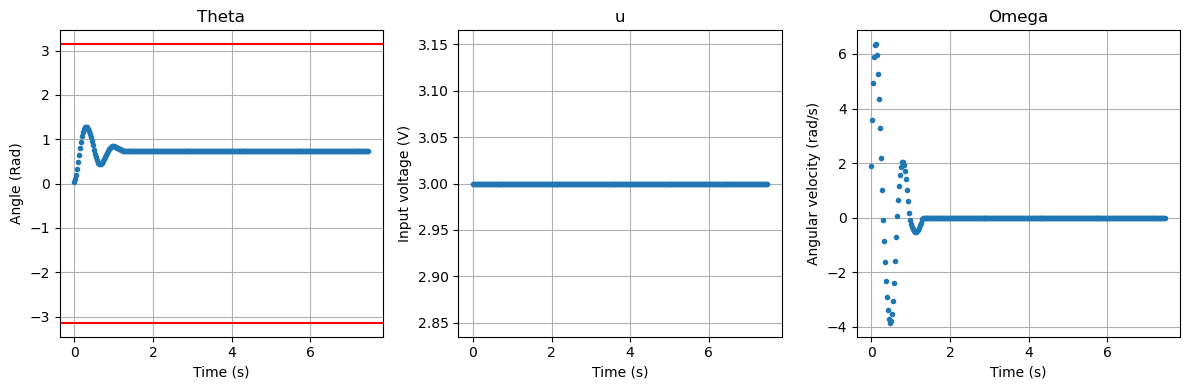

In [10]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot theta
axs[0].plot([i*env.dt for i in range(max_episode_steps)], theta, '.')
axs[0].set_title('Theta')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Angle (Rad)')
axs[0].axhline(y=target_angle, color='r', linestyle='-')
axs[0].axhline(y=-target_angle, color='r', linestyle='-')
axs[0].grid(True)

# Plot u
axs[1].plot([i*env.dt for i in range(max_episode_steps)], u, '.')
axs[1].set_title('u')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Input voltage (V)')
axs[1].grid(True)

# Plot omega
axs[2].plot([i*env.dt for i in range(max_episode_steps)], omega, '.')
axs[2].set_title('Omega')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Angular velocity (rad/s)')
axs[2].grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

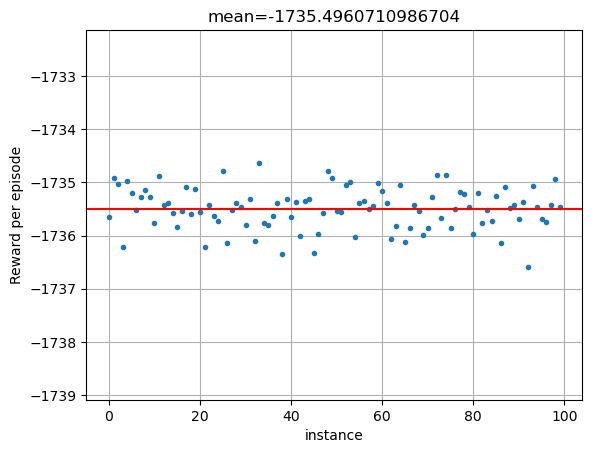

In [11]:
from matplotlib import pyplot as plt
Rewards = [eval_Q(Q,env) for i in range(100)]
plt.plot(Rewards,'.')
plt.title(f'mean={np.mean(Rewards)}')
plt.xlabel('instance')
plt.ylabel('Reward per episode')
plt.ylim(np.min(Rewards)-2.5, np.max(Rewards)+2.5)
plt.axhline(y=np.mean(Rewards), color='r', linestyle='-')
plt.grid(True)
plt.show()

if np.mean(Rewards) > 1600:
    save_Qfunction(Q)